# SVMs (Support Vector Machines) con datos sintéticos

Basado en el capítulo 9 del libro "Introduction to Statistical Learning" de Gareth James, Daniela Witten, Trevor Hastie y Robert Tibshirani.

Cargamos las librerías

**EXPLICACIÓN**: Se cargan las librerias a utilizar.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action=‘ignore’,category=DeprecationWarning)
#warnings.filterwarnings(action=‘ignore’,category=FutureWarning)

## 1. Creación de un dataset sintético aleatorio

Inicialmente, vamos a generar aleatoriamente un dataset sencillo de ensayo (20 instancias) para comprender como funciona el algoritmo SVM con un kernel lineal. El dataset va a tener dos variables numéricas predictoras (x1 y x2) y una clase (y)

**EXPLICACIÓN**: Se crea un dataset sintetico, donde primero se define una semilla para que el experimento sea reproducible, despues se genera un ndarray de numpy compuesto por 20 filas y 2 columnas, siendo cada fila una observacion diferente y las dos columnas son las 2 variables del set de datos. Posteriormente, se generan las etiquetas para las dos clases o categorias, donde estas se definen con un numero 1 para una categoria y un numero -1 para la otra.

Por ultimo se desplazan las observaciones que pertenecen a la categoria -1 hacia la derecha para ayudar en la separabilidad lineal.

In [2]:
np.random.seed(5)
X = np.random.randn(20,2)
y = np.repeat([1,-1], 10)

# Trasladamos los puntos de la clase negativa un poco a la izquierda, para incentivar la separabilidad lineal
X[y == -1] = X[y == -1] +1  

Creamos un dataframe con los datos anteriores

**EXPLICACIÓN**: e crea un dataframe de pandas concatenando horizontalmente las 2 variables independientes creadas anteriormente (X) con la variable dependiente (y) y ademas se le asignan los nombres a cada una de las columnas; por ultimo se muestran los 5 primeros registros del dataframe creado.

In [3]:
df_0 = pd.concat([    pd.DataFrame(X), pd.DataFrame(y)   ], axis = 1)
df_0.columns = ['x1', 'x2', 'y']
df_0.head()

,x1,x2,y
0,0.441227,-0.330870,1
1,2.430771,-0.252092,1
2,0.109610,1.582481,1
3,-0.909232,-0.591637,1
4,0.187603,-0.329870,1


**EXPLICACIÓN**: Se realiza la tabla de frecuencias para la variable dependiente donde se observar cuantos registros pertenecen a cada una de las categorias generadas. Se observa que el dataset esta balanceado puesto que todas las etiquetas poseen el mismo numero de registros.

In [4]:
pd.crosstab(index=df_0["y"], columns="count")

col_0,count
y,
-1,10
1,10


Vamos a ilustrar un particionamiento posible con los dataframes, usando el método **groupby**.
La idea es poder obtener subconjuntos de datos dados diferentes valores de una misma variable categórica.
En este caso, tenemos la varible objetivo *y*, que nos servirá como criterio de particionamiento.

El método *groupby* retorna una tupla con la categoría de la variable particionada (-1 o +1), y un dataframe con los registros correspondientes a cada categoría, incluyendo el índice (de la fila original) de los registros correspondientes.

**EXPLICACIÓN**: Se imprime en consola los registros que pertenecen a cada categoria en forma de tuplas utilizando el metodo groupby.

In [5]:
for name, group in df_0.groupby('y'):
    print("Grupo para la clase {}\n{}".format(name, group))

Grupo para la clase -1
          x1        x2  y
10  0.019392  0.143147 -1
11  0.128121  0.577492 -1
12  1.996440  1.712421 -1
13  1.059144  0.636689 -1
14  1.003289  0.894070 -1
15  1.793053  0.368428 -1
16  0.993805  0.898932 -1
17  0.947692  1.249218 -1
18  1.197660  2.334849 -1
19  0.913124  2.561532 -1
Grupo para la clase 1
         x1        x2  y
0  0.441227 -0.330870  1
1  2.430771 -0.252092  1
2  0.109610  1.582481  1
3 -0.909232 -0.591637  1
4  0.187603 -0.329870  1
5 -1.192765 -0.204877  1
6 -0.358829  0.603472  1
7 -1.664789 -0.700179  1
8  1.151391  1.857331  1
9 -1.511180  0.644848  1


Vamos entonces a visualizar los datos en un scatterplot para poder entenderlos mejor. Vamos a utilizar un scatterplot y un gráfico de densidad de 2 dimensiones.

**EXPLICACIÓN**: Se visualizan los datos por cada categoria en forma de un grafico de dispersion y un grafico KDE, donde es posible analizar como existe un solapamiento marcado entre los registros de las dos categorias.

Text(0.5, 1.0, 'Densidad de puntos: x1 vs. x2')

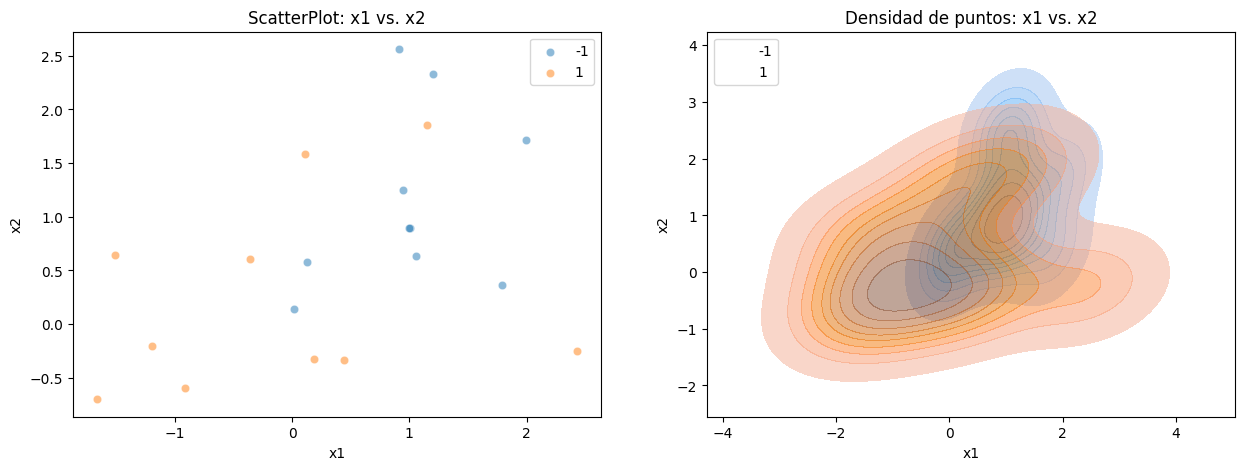

In [6]:
fig, axs = plt.subplots(figsize=[15, 5], ncols=2, nrows=1)

for name, group in df_0.groupby('y'):
    sns.scatterplot(x="x1", y="x2", data=group, alpha=0.5, label=name, ax=axs[0])    
axs[0].legend()
axs[0].set_title("ScatterPlot: x1 vs. x2")

for name, group in df_0.groupby('y'):
    sns.kdeplot(data=group["x1"], data2=group["x2"], shade=True, shade_lowest=False, alpha=0.5,
                label=name, ax=axs[1])    
axs[1].legend(loc=2)
axs[1].set_title("Densidad de puntos: x1 vs. x2")

## 2. Entrenamiento de un modelo SVM de Clasificación

En Python, los modelos SVM de clasificación son representados por la clase **SVC**. En el caso de clasificación con más de 2 clases, **SVC** adopta una aproximación "uno contra uno" para determinar la clase final.

Esta clase se crea con los siguientes parámetros:

- *C*: valor de la penalidad de una instancia por violación de las márgenes (1 por defecto); controla la regularización. A menor valor de C, mayor amplitud de la margen del clasificador
- *kernel*: el tipo de kernel a utilizar ('rbf' por defecto); otros valores aceptados son: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’. Se puede definir un kernel implementado en una clase por fuera del API. 
- *degree*: grado del polinomio en el caso del kernel 'poly' (3 por defecto); se ignora para otros kernels.
- *gamma*: determina la dispersión alrededor de los vectores de soporte ('auto' por defecto); solo se considera para los kernels ‘rbf’, ‘poly’ y ‘sigmoid’. A mayor *gamma*, mayor complejidad (dimensionalidad) del espacio de representación de las instancias.
- *probability* : Indica si se deben generar estimados de probabilidad de clase (False por defecto), lo que implicaría un costo en el tiempo de procesamiento.

Intentamos la clasificación con un kernel **lineal**, usando entonces un **clasificador de margen suave**. Como los datos no son linealmente separables, es necesario establecer un valor de C > 0.

**EXPLICACIÓN**: Se contruye el modelo de maquina de soporte vectorial cuyo kernel se define como uno lineal y ademas se define el hiperparametro de regularizacion/penalizacion por violacion del margen respecto al umbral de decision, siendo este valor C=1.

In [7]:
svc = SVC(C=1, kernel='linear')

A manera de ilustración, vamos a entrenarlo con todo el dataset (uds ya saben que esto no se debe hacer!!! Pero vamos a ir aumentando la complejidad del proceso poco a poco).

**EXPLICACIÓN**: Se entrena el modelo SVM con los datos de entrenamiento (x,y)

In [8]:
svc.fit(X, y)

SVC(C=1, kernel='linear')

En el modelo entrenado podemos tener acceso a los vectores de soporte

In [9]:
print("De los {} puntos de entrenamiento, {} son vectores de soporte".format(len(y), len(svc.support_)))

De los 20 puntos de entrenamiento, 13 son vectores de soporte


Vamos a definir una función **plot_svc** (tomado de R. Jordan Crouser @ Smith College) que nos permitirá visualizar los resultados de la aplicación de un modelo de SVM para la clasificación de un conjunto de datos. Recibe:

- svc: El modelo entrenado de tipo SVC
- X: La matriz con las variables predictoras X, del dataset a evaluar
- y: El array con las clases verdaderas correspondientes, del dataset a evaluar
- pad: El tamaño del borde a dejar sin puntos, valor por defecto 0.25
- h: la distancia entre los puntos en la grilla a evaluar, valor por defecto 0.02

**EXPLICACIÓN**: Se contruye un metodo que permita graficar el resultado de la clasificacion realizada por la maquina de soporte vectorial, donde ademas se puedra visualizar las observaciones que el algoritmo definio como los vectores de soporte y tambien la frontera de decision.

In [10]:
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    # Determinamos los límites del plot a gráficar
    x1_min, x1_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    x2_min, x2_max = X[:, 1].min()-pad, X[:, 1].max()+pad

    # Creamos una grilla de puntos que se van a enviar al clasificador (meshgrid)
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    
    # Usando unravel(), vamos aplanar las matrices xx1 y xx2, creando una gran lista de puntos que se enviarán al modelo
    Z = svc.predict(np.c_[xx1.ravel(), xx2.ravel()]) #En Z quedan las clases predichas para cada punto de la grilla

    # Ploteamos la grilla con sus clases
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, cmap=plt.cm.Paired, alpha=0.2)

    # Ploteamos los puntos evaluados con sus clases reales
    plt.scatter(X[:, 0], X[:, 1], s=70, c=y, cmap=plt.cm.Paired)

    # Identificamos los vectores de soporte del modelo con una x
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', linewidths=2)

    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()    

Veamos como nos va con todo el dataset:

**EXPLICACIÓN**: Se realiza un grafico de dispersion donde se visualiza el resultado de la clasificacion realizada por la maquina de soporte vectorial entrenada anteriormente, en este se mapean en un espacio bidimensional las dos variables independientes, cuyos colores reflejan a cual de las dos categorias pertenecen. Ademas de lo anterior se puede observar las dos regiones separadas por la frontera de decision y ademas, con una X se visualizan que observaciones fueron definidas como vectores de soporte por el algoritmo.

Se puede destacar el hecho que no es posible separar completamente las observaciones de cada categoria de forma lineal puesto que se encuentran superpuestos.

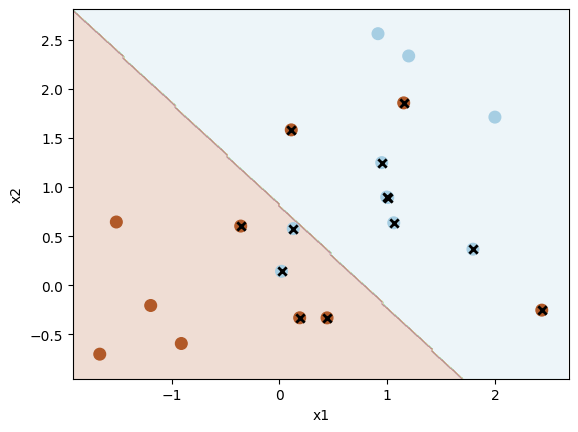

In [11]:
plot_svc(svc, X, y)

Vemos el espacio de representación bidimensional de los datos dividido en 2 por una frontera de decisión dada por el clasificador. Dado el kernel utilizado por el modelo, la frontera es lineal.

Encontramos unos cuantos errores, y podemos ver los puntos que intervienen como **vectores de soporte**, graficados con una "x". Podemos ver que estos puntos están cerca de la frontera de decisión. Algunos de ellos están en el lado de decisión incorrecto, no solo violan la margen, sino que quedan mal clasificados. Otros puntos están en el buen lado, pero violan la margen establecida por el clasificador (la margen no es visible).

Podemos identificar los vectores de soporte con las variables **support_**, que indica los índices de los puntos, y **support_vectors_**, que contiene su representación en el espacio de las variables independientes:

**EXPLICACIÓN**: Se muestran los indices de las observaciones en el dataset de entrenamiento que fueron definidas como vectores de soporte por el algoritmo.

In [12]:
svc.support_

array([10, 11, 13, 14, 15, 16, 17,  0,  1,  2,  4,  6,  8])

**EXPLICACIÓN**: Se muestran las observaciones que corresponden a los vectores de soporte definidos por el algoritmo.

In [13]:
svc.support_vectors_

array([[ 0.01939211,  0.14314685],
       [ 0.12812082,  0.57749207],
       [ 1.05914424,  0.63668912],
       [ 1.00328884,  0.89406956],
       [ 1.79305332,  0.36842837],
       [ 0.99380509,  0.89893239],
       [ 0.94769185,  1.24921766],
       [ 0.44122749, -0.33087015],
       [ 2.43077119, -0.25209213],
       [ 0.10960984,  1.58248112],
       [ 0.18760323, -0.32986996],
       [-0.35882895,  0.6034716 ],
       [ 1.15139101,  1.85733101]])

El parámetro *C* del modelo controla el valor de cada violación de la margen. 
Se trata de un parámetro de regularización que permite encontrar un balance entre las contribuciones del error de sesgo y de varianza.

Entre más pequeño sea de *C*, mayor sera la margen y mas puntos quedarán identificados como vectores de soporte (tendiendo hacia el **underfitting**). 
Al contrario, entre más grande sea *C*, mayor la margen y menor la cantidad de vectores de soporte (tendiendo hacia el **overfitting**). 

Vamos ahora a utilizar la clase **GridSearchCV** para aplicar el protocolo de evaluación de cross-validation y así poder estimar la mejor combinación de valores de los parámetros configurables de un modelo. Variaremos *C*, utilizando *accuracy* como métrica de evaluación.

En total se evaluarán 7 valores de cada uno de los dos parámetros, por lo que ensayaremos se crearán 7 modelos con configuraciones diferentes, cada uno con varias repeticiones de cross-validation.

**EXPLICACIÓN**: Se aplica la clase GridSearchCV al modelo de maquina de soporte vectorial con kernel lineal para efectuar un proceso de validacion cruzada con el objetivo encontrar que hiperparametro de regularizacion C dentro del conjunto de valores [0.001, 0.01, 0.1, 1, 5, 10, 100] es el mas indicado para obtener las mejores metricas de rendimiento, donde en este caso, la matrica a maximizar con dicha busqueda es la del accuracy y esta se realizara aplicando un 10-Fold a cada modelo generado. Definido los parametros de la grid de busqueda de validacion cruzada se realiza el entrenamiento.

In [14]:
parametros = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
clf = GridSearchCV(SVC(kernel='linear'), # el modelo a configurar
                   parametros, # los parámetros con los valores a ensayar
                   cv=10, # para cada modelo se hacen 10 repeticiones
                   scoring='accuracy', # métrica de evaluación a considerar para decidir el mejor modelo
                   return_train_score=True) # guardar en memoria los valores de las métricas de evaluación
clf.fit(X, y)

GridSearchCV(cv=10, estimator=SVC(kernel='linear'),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}],
             return_train_score=True, scoring='accuracy')

La búsqueda por grilla graba la configuración y los resultados de la evaluación del mejor modelo:

**EXPLICACIÓN**: Despues de realizado el entrenamiento aplicando la grid de busqueda mediante validacion cruzada, se despliegan los resultados, donde estos muestran el modelo que logro obtener la mejor estimacion, el indice de dicho modelo en la lista de modelos generados, el valor del hiperparametro de regularizacion C que maximizo la metrica del accuracy, que en este caso es C=0.001, el accuracy mas alto obtenido, el cual es del 80% y por ultimo se lista el resumen de los resultados obtenidos en cada evaluacion.

In [15]:
clf.best_estimator_

SVC(C=0.001, kernel='linear')

In [16]:
clf.best_index_

0

In [17]:
clf.best_params_

{'C': 0.001}

In [18]:
clf.best_score_

0.8

Podemos acceder a los resultados de las evaluaciones, utilizando el diccionario que queda en la variable cv_results_.
Se puede consultar en su totalidad:

In [19]:
clf.cv_results_

{'mean_fit_time': array([0.00060008, 0.00060065, 0.00080833, 0.00059788, 0.00019724,
        0.00050085, 0.00059817]),
 'std_fit_time': array([0.00048996, 0.00049043, 0.00040442, 0.00048829, 0.00039455,
        0.000501  , 0.00048842]),
 'mean_score_time': array([2.99787521e-04, 4.98890877e-04, 9.98735428e-05, 1.99699402e-04,
        5.01775742e-04, 5.04088402e-04, 9.99212265e-05]),
 'std_score_time': array([0.00045794, 0.00049911, 0.00029962, 0.0003994 , 0.00050184,
        0.00050433, 0.00029976]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 5, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 5},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'split1_test_score': array([0.5, 0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'split2_test_score': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 '

**EXPLICACIÓN**: Se muestran las llaves del diccionario que contiene los resultados obtenidos en el proceso de validacion cruzada.

In [20]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

También se puede consultar elemento por elemento, dado que es un diccionario:

**EXPLICACIÓN**: Se visualiza el promedio del accuracy que obtuvieron los 7 modelos generados a partir de la variacion del hiperparametro de regularizacion en cada una de las 10 evaluacion realizadas mediante el 10-Fold aplicado a cada uno.

In [21]:
clf.cv_results_['mean_train_score']

array([0.79444444, 0.79444444, 0.75      , 0.77777778, 0.76666667,
       0.76666667, 0.76666667])

## 3. Predicción con el modelo entrenado

Creamos un SVC con kernel lineal y la mejor configuración encontrada (C=0.001) y lo usamos para predecir las clases, utilizando el método **predict** sobre un nuevo dataset de test que siga el mismo proceso generador del dataset de entrenamiento.

**EXPLICACIÓN**: Se genera un dataset de prueba de la misma manera a como se construyo el dataset de entrenamiento, la diferencia es la semilla utilizada para la obtencion de los puntos aleatorios.

In [22]:
np.random.seed(1)
X_test = np.random.randn(20,2)
y_test = np.random.choice([-1,1], 20)
X_test[y_test == 1] = X_test[y_test == 1] -1

**EXPLICACIÓN**: Se construye una maquina de soporte vectorial con un kernel lineal y con el valor del hiperparametro de regularizacion que obtuvo el mayor accuracy calculado anteriormente, donde ademas se le define al algoritmo que brinde las probabilidades de pertenencia de cada observacion a la categorias despues de realizar la clasificacion.

Despues de lo anterior, este se entrena con el dataset de entrenamiento generado con anterioridad y despues se generan las predicciones de los datos de prueba X_test generados anteriormente. Por ultimo, se crea un dataframe donde se plasma la matriz de confusion de los resultados de la clasificacion realizada por el algoritmo con el conjunto de datos de prueba; en esta matriz se observa que se clasificaron correctamente 14 observaciones de las 20 ingresadas.

In [23]:
svc2 = SVC(C=0.001, kernel='linear', probability=True)
svc2.fit(X, y)
y_pred = svc2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), index=svc2.classes_, columns=svc2.classes_)

,-1,1
-1,2,6
1,0,12


Tenemos 14 instancias bien clasificadas.

Podemos obtener el valor de decisión que permite eventualmente ver que tan lejos se está o no de las márgenes, y en que lado:

**EXPLICACIÓN**: Se muestra el valor de decision para cada observacion del set de prueba, donde la magnitud de este refleja que tan lejos se encuentra cada observacion respecto a la margenes definidas por la frontera de decision (nivel de confianza) y el signo explica en que lado de la frontera de decision se encuentra cada observacion.

In [24]:
svc2.decision_function(X_test)

array([-0.00640968,  0.04272221,  0.03805787,  0.01404668,  0.02559796,
        0.02907835,  0.03411535,  0.00360828,  0.01643692,  0.02117352,
        0.0290528 , -0.00833112,  0.00246969,  0.03686675,  0.00470993,
        0.01796234,  0.02199141,  0.03470184,  0.03752468,  0.00133622])

Aquí podemos ver que solo hay dos puntos clasificados en la clase negativa, y la magnitud de este valor nos indica el nivel de confianza del clasificador, tal como lo indican las probabilidades de clase que se obtienen con la función **predict_proba** (solo disponible si se ha creado el objeto **SVC** con probability=True.

**EXPLICACIÓN**: Se obtienen las probabilidades de pertenencia de cada observacion a las categorias definidas, donde cada columna refleja la probabilidad de pertenencia de cada registro a cada clase, siendo en este caso 2 columnas debido a que se tienen 2 categorias. Visualizando las probabilidades se puede destacar el hecho de que casi todas las observaciones pertenecen a la categoria 1 ya que la probabilidad de pertenecer a dicha clase es mayor que la de pertenecer a la categoria 2; ademas, se puede visualizar como en muchos casos no existe una fuerte diferencia en las probabilidades de pertenencia.

In [25]:
svc2.predict_proba(X_test)

array([[0.5       , 0.5       ],
       [0.5096755 , 0.4903245 ],
       [0.50866944, 0.49133056],
       [0.5       , 0.5       ],
       [0.5059816 , 0.4940184 ],
       [0.50673243, 0.49326757],
       [0.50781902, 0.49218098],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.50502707, 0.49497293],
       [0.50672692, 0.49327308],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.50841252, 0.49158748],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.50520352, 0.49479648],
       [0.50794553, 0.49205447],
       [0.50855443, 0.49144557],
       [0.5       , 0.5       ]])

## 4. SVMs con un dataset linealmente separable

Modificamos el dataset de test anterior para que sea apenas linealmente separable (muy justo), y analizamos los resultados de varias configuraciones de un SVM aprendido sobre él

**EXPLICACIÓN**: Se modifica el dataset de prueba creado anteriormente para que esta vez los dos conjuntos de observaciones sean apenas linealmente separables entre si, moviendo el conjunto de datos de la categoria 2 (Etiqueta = 1) a la izquierda.

In [26]:
X_test[y_test == 1] = X_test[y_test == 1] -1

**EXPLICACIÓN**: Se realiza el grafico de dispersion para el set de prueba modificado donde se puede observar que existe una separacion lo suficientemente grande para que los dos conjuntos/categorias sean linealmente separables.

Text(0, 0.5, 'X2')

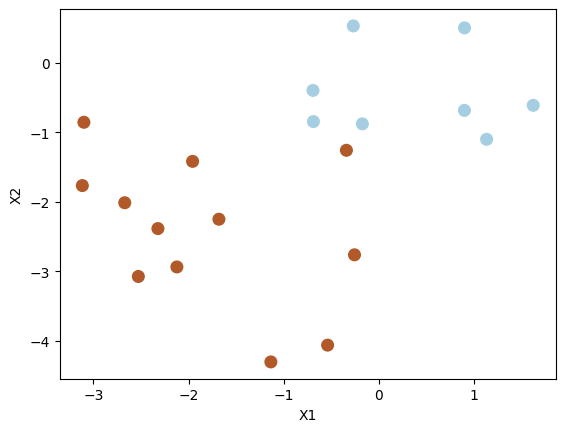

In [27]:
plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')

Entrenemos un modelo que garantice que todas las instancias están bien clasificadas, acercándose a lo que sería un **clasificador de margen dura**. Para tal motivo, vamos a especificar un gran valor del parámetro *C* (10000), para que cada error tenga un gran valor y se busque la perfección de la clasificación del set de entrenamiento.

**EXPLICACIÓN**: Se construye y se entrena un modelo SVM con kernel lineal y un hiperparametro de regularizacion C=1e5, donde el valor de este ultimo parametro al ser tan elevado, propiciara que los errores de clasificacion sean fuertemente penalizados y el modelo buscara que todas las observaciones se clasifiquen correctamente sin excepciones, realizandose de esta manera una clasificacion de margen dura o maximo margen.

Ademas de lo anterior, despues de ser entrenado el modelo, se realiza la grafica de dispersion donde se visualiza la clasificacion de las observaciones del set de datos de prueba, las regiones separadas por la frontera de decision calculada y las observaciones que fueron definidas como vectores de soporte por el algoritmo. Se puede observar como al no existir errores en la clasificacion, la margen generada por el algoritmo es muy angosta y al tener en cuenta pocos vectores de soporte, el modelo sufre de overfitting.

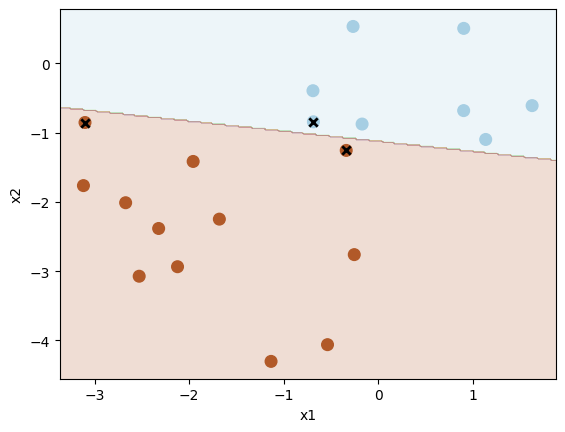

In [28]:
svc3 = SVC(C=1e5, kernel='linear')
svc3.fit(X_test, y_test)
plot_svc(svc3, X_test, y_test)

Vemos que en efecto que no hubo errores en el entrenamiento, y que solo tenemos 3 vectores de soporte.
Como hay muchos puntos cercanos a la frontera de decisión que no son vectores de soporte, podemos asimilar que la margen es bastante angosta.
Podríamos estimar que este modelo es demasiado rigido y no tiene una buena capacidad de generalización (overfitting).

Intentemos con un valor de C=1.

**EXPLICACIÓN**: Se construye y se entrena nuevamente un modelo SVM con kernel lineal pero esta vez con un hiperhiperparametro de regularizacion C=1, lo cual causara que el modelo sea mas laxo en cuanto a los errores de clasificacion y por lo tanto se realice una clasificacion de margen suave.

En el grafico de dispersion generado se refleja el resultado de la clasificacion realizada por el algoritmo donde se puede observar que existen pocos errores de clasificacion y ademas, el modelo tuvo en cuenta una mayor cantidad de vectores de soporte para la generacion de la frontera de decision, causando asi que se tenga un modelo mas robusto y con menos tendencia al sobre-entrenamiento.

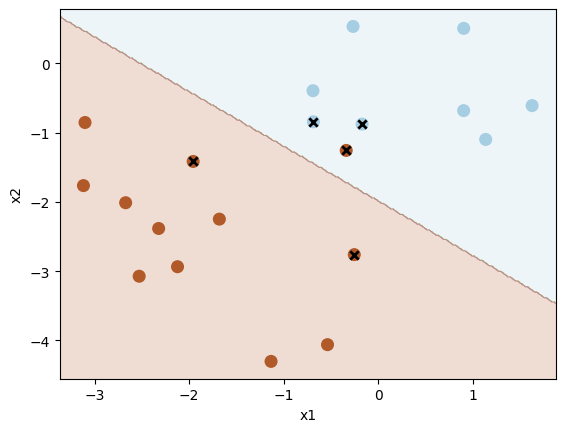

In [29]:
svc4 = SVC(C=1, kernel='linear')
svc4.fit(X_test, y_test)
plot_svc(svc4, X_test, y_test)

Aunque hay un error, vemos que hay una mayor cantidad de vectores de soporte alejados de la frontera de decisión, por lo que este modelo puede ser mas robusto frente al overfitting.

## 5. Creación de un dataset sintético no linealmente separable

Ahora, vamos a generar aleatoriamente un dataset sencillo de ensayo (300 instancias) para comprender como funciona el algoritmo, que va a tener dos variables numéricas predictoras (x1 y x2) y una clase (y):

- Las primeras 100 instancias van a tener valores pequeños en las dos variables, y se asignarán a la clase -1
- Las 100 instancias intermedias van a tener valores medianos en las dos variables, y se asignarán a la clase +1
- Las últimas 100 instancias van a tener valores grandes en las dos variables, y se asignarán a la clase -1

**EXPLICACIÓN**: Se construye un nuevo dataset, donde el objetivo es que este no sea linealmente separable, para ello se genera un ndarray de numpy compuesto por 300 filas y 2 columnas, siendo estas dos columnas las 2 variables independientes del set de datos, ademas de lo anterior se generan 2 desplazamientos en 2 porciones de los datos diferentes para asi ocacionar que la porcion de la mitad pertenezca a una clase y las dos porciones de los lados pertenezcan a la otra.

In [30]:
np.random.seed(12345)
X = np.random.randn(300,2)
X[:100] = X[:100] -2.5
X[201:] = X[201:] +2.5
y = np.concatenate([np.repeat(-1, 100), np.repeat(1,100), np.repeat(-1, 100)])

Creamos un dataframe con los datos anteriores

**EXPLICACIÓN**: Se crea un dataframe donde se concatenan horizontalmente las variables independientes (X) con la variable dependiente (y) y se nombran las columnas.

In [31]:
df_0 = pd.concat([    pd.DataFrame(X), pd.DataFrame(y)   ], axis = 1)
df_0.columns = ['x1', 'x2', 'y']

Agrupamos por clases y visualizamos los datos

**EXPLICACIÓN**: Se realiza un grafico de dispersion junto a un grafico KDE del set de datos generado, donde se puede visualizar el hecho de que no es posible separar linealmente las dos categorias definidas.

Text(0.5, 1.0, 'Densidad de puntos: x1 vs. x2')

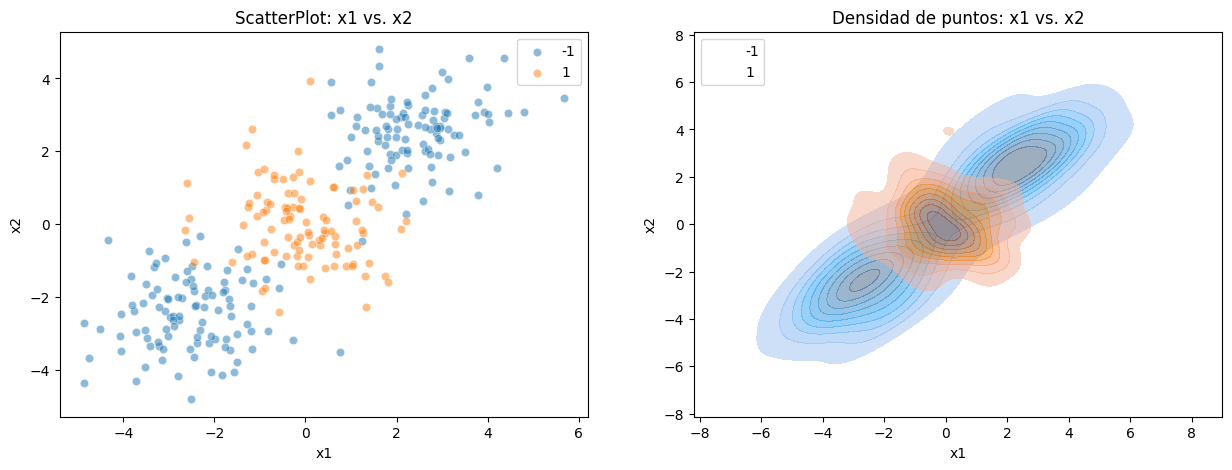

In [32]:
fig, axs = plt.subplots(figsize=[15, 5], ncols=2, nrows=1)

for name, group in df_0.groupby('y'):
    sns.scatterplot(x="x1", y="x2", data=group, alpha=0.5, label=name, ax=axs[0])    
axs[0].legend()
axs[0].set_title("ScatterPlot: x1 vs. x2")

for name, group in df_0.groupby('y'):
    sns.kdeplot(data=group["x1"], data2=group["x2"], shade=True, shade_lowest=False, alpha=0.5,
                label=name, ax=axs[1])    
axs[1].legend(loc=2)
axs[1].set_title("Densidad de puntos: x1 vs. x2")

### Entrenamiento y búsqueda de parámetros para un modelo SVM de Clasificación

Vamos a generar un conjunto de datos de entrenamiento y un set de evaluación utilizando la función **train_test_split**, dejando el 70% de los datos en el primer conjunto.

**EXPLICACIÓN**: Se realiza el particionamiento del set de datos en los conjuntos de entrenamiento y validacion, donde el 70% de los datos sera destinado al entrenamiento.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=666)

Vamos a crear un clasificador SVM con la clase **SVC**, a entrenarlo y a visualizar su frontera de clasificación y su error de test:

**EXPLICACIÓN**: Se construye y se entrena un clasificador SVM cuyo kernel es rbf (Radial Basis Function) y su hiperparametro de regularizacion/penalizacion C y del ancho de la funcion gaussiana ($\gamma$) se definieron con los valores 10 y 1 respectivamente.

Posterior a lo anterior, se realiza el grafico de dispersion con la frontera de decision del clasificador entrenado y ademas se obtiene el numero de observaciones que fueron definidos por parte del algoritmo como vectores de soporte

De los 210 puntos de entrenamiento, 59 son vectores de soporte


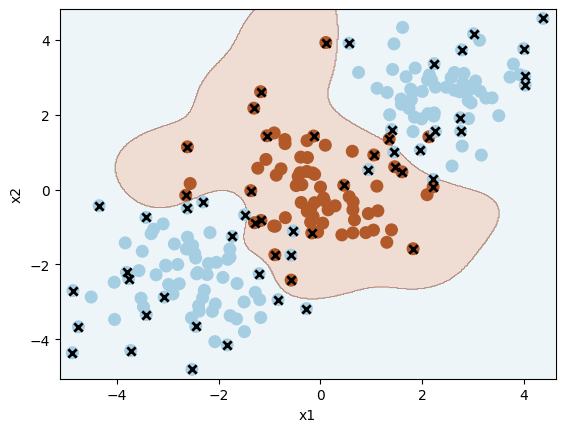

In [34]:
svc3 = SVC(C=10, kernel='rbf', gamma=1)
svc3.fit(X_train, y_train)
print("De los {} puntos de entrenamiento, {} son vectores de soporte".format(len(y_train), len(svc3.support_)))
plot_svc(svc3, X_train, y_train)

**EXPLICACIÓN**: Se obtiene el grafico de dispersion con la frontera de decision del resultado de la clasificacion del modelo entrenado con el set de validacion/prueba.

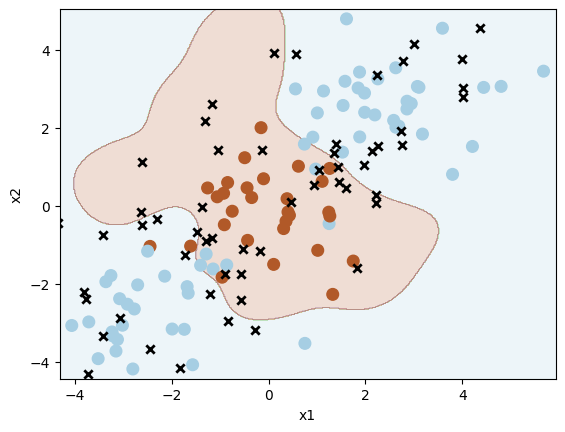

In [35]:
plot_svc(svc3, X_test, y_test)

**EXPLICACIÓN**: Se realizan las matrices de confusion para el resultado de la clasificacion del modelo, donde se observan tanto los errores de validacion/prueba como los errores de entrenamiento.

In [36]:
y_pred = svc3.predict(X_train)
pd.DataFrame(confusion_matrix(y_train, y_pred), index=svc3.classes_, columns=svc3.classes_)

,-1,1
-1,134,5
1,2,69


In [37]:
y_pred = svc3.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), index=svc3.classes_, columns=svc3.classes_)

,-1,1
-1,54,7
1,2,27


Con C=10, encontramos 7 errores de entrenamiento y 9 errores de test de 90 (90% de accuracy).

Veamos que pasa si incrementamos el valor de la sensibilidad a los errores a 100, haciendo que la margen sea más angosta.

**EXPLICACIÓN**: Se construye y se entrena un clasificador SVM cuyo kernel es rbf (Radial Basis Function) y su hiperparametro de regularizacion/penalizacion C y del ancho de la funcion gaussiana ($\gamma$) se definieron con los valores 100 y 1 respectivamente.

Mediante el grafico de dispersión con la frontera de decision resultante, se puede observar como el modelo tuvo tendencia al overfitting debido clasifico correctamente todas las observaciones., ajustándose demasiado bien a los datos de entrenenamiento y obteniendose un poder de generalizacion no optimo.

De los 210 puntos de entrenamiento, 43 son vectores de soporte


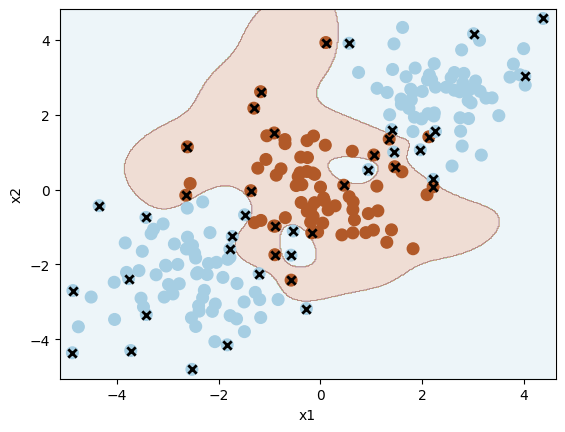

In [38]:
# Increasing C parameter, allowing more flexibility
svc4 = SVC(C=100, kernel='rbf', gamma=1.0)
svc4.fit(X_train, y_train)
print("De los {} puntos de entrenamiento, {} son vectores de soporte".format(len(y_train), len(svc4.support_)))
plot_svc(svc4, X_train, y_train)

Vemos que empieza a presentar overfitting, con una frontera de decisión más compleja que incluye "islas" para evitar errores. 
En cuanto a la calidad de las predicciones tenemos:

**EXPLICACIÓN**: Se realizan las matrices de confusion para el resultado de la clasificacion del modelo, donde se observa que este tuvo 2 errores de entrenamiento y 12 errores de validacion/prueba. Debido a lo anterior, se puede exponer que el presente modelo tuvo mayor numero de errores de validacion con un C=100 que el anterior con un C=10, a causa del overfitting.

In [39]:
y_pred = svc4.predict(X_train)
pd.DataFrame(confusion_matrix(y_train, y_pred), index=svc4.classes_, columns=svc4.classes_)

,-1,1
-1,138,1
1,1,70


In [40]:
y_pred = svc4.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), index=svc3.classes_, columns=svc3.classes_)

,-1,1
-1,53,8
1,3,26


Con C=100, encontramos 2 errores de entrenamiento y 53 errores de test de 90 (41.1% de accuracy).

Ahora, hagamos variar el parámetro **gamma**, del kernel **rbf**, que controla la amplitud de la gaussiana. Teniendo en cuenta que el valor original era 1, analicemos el efecto de utilizar valores más pequeños (0.1) y más grandes (5).

**EXPLICACIÓN**: Se construye y se entrena un clasificador SVM cuyo kernel es rbf (Radial Basis Function) y su hiperparametro de regularizacion/penalizacion C y del ancho de la funcion gaussiana ($\gamma$) se definieron con los valores 10 y 0.1 respectivamente.

Mediante el grafico de dispersión con la frontera de decision resultante, se puede observar como el modelo tuvo tendencia al underfitting, debido a que se tomaron pocas observaciones como vectores de soporte.

De los 210 puntos de entrenamiento, 32 son vectores de soporte


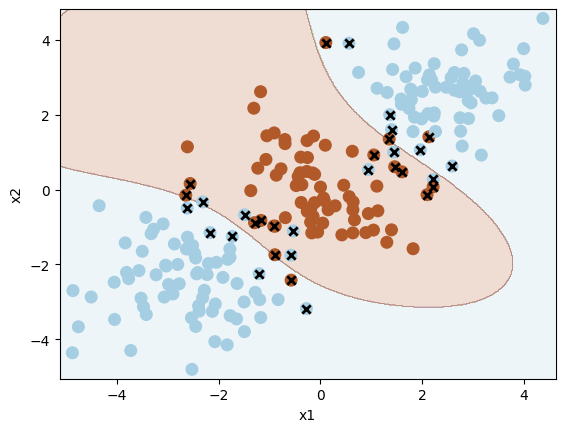

In [41]:
svc5 = SVC(C=10, kernel='rbf', gamma=0.1)
svc5.fit(X_train, y_train)
print("De los {} puntos de entrenamiento, {} son vectores de soporte".format(len(y_train), len(svc5.support_)))
plot_svc(svc5, X_train, y_train)

Encontramos que a menor **gamma**, mas sencillo el modelo,  menor número de vectores de soporte y se tiende hacia el underfitting.

**EXPLICACIÓN**: Se construye y se entrena un clasificador SVM cuyo kernel es rbf (Radial Basis Function) y su hiperparametro de regularizacion/penalizacion C y del ancho de la funcion gaussiana ($\gamma$) se definieron con los valores 10 y 5 respectivamente.

Mediante el grafico de dispersión con la frontera de decision resultante, se puede observar como el modelo tuvo tendencia al overfitting, debido a que esta vez se tomaron muchas observaciones como vectores de soporte, creando asi una frontera de decision muy compleja y rigida.

De los 210 puntos de entrenamiento, 145 son vectores de soporte


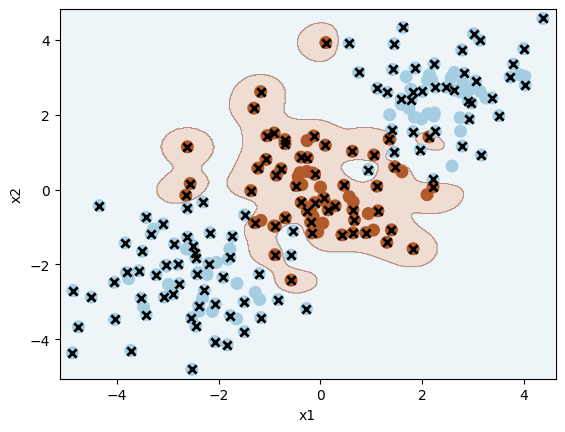

In [42]:
svc6 = SVC(C=10, kernel='rbf', gamma=5)
svc6.fit(X_train, y_train)
print("De los {} puntos de entrenamiento, {} son vectores de soporte".format(len(y_train), len(svc6.support_)))
plot_svc(svc6, X_train, y_train)

Encontramos que entre mayor el **gamma**, mas complejo el modelo por lo que más vectores de soporte, y mas overfitting.

Utilicemos ahora **GridSearchCV** para estimar la mejor combinación de valores de los parámetros configurables (en este caso variaremos *C* y *gamma*), con respecto a una métrica de evaluación (en este caso utilizaremos el *accuracy*).
En total se evaluarán 5 valores de cada uno de los dos parámetros, por lo que ensayaremos con 25 configuraciones diferentes.

**EXPLICACIÓN**: Se aplica la clase GridSearchCV al modelo de maquina de soporte vectorial con kernel RBF para efectuar un proceso de validacion cruzada con el objetivo encontrar que valor del hiperparametro de regularizacion C dentro del conjunto [0.01, 0.1, 1, 10, 100] y que valor del hiperparametro gamma dentro del conjunto [0.5,1,2,3,4] son los que obtienen las mejores metricas de rendimiento, donde en este caso, la matrica a maximizar con dicha busqueda es la del accuracy y esta se realizara aplicando un 10-Fold a cada modelo generado. Definido los parametros de la grid de busqueda de validacion cruzada se realiza el entrenamiento.

In [43]:
# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'gamma': [0.5, 1,2,3,4]}]
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.5, 1, 2, 3, 4]}],
             return_train_score=True, scoring='accuracy')

Encontramos que la mejor configuración fue C=1 con gamma=1:

**EXPLICACIÓN**: Despues de realizado el entrenamiento aplicando la grid de busqueda mediante validacion cruzada, se despliegan los resultados, donde se muestran para el mejor modelo obtenido sus hiperparametros (C=1 y gamma=1), su matriz de confusion donde se obtuvo 8 errores de prueba y el valor de su metrica de accuracy con un 91.1%, 

In [44]:
clf.best_params_

{'C': 1, 'gamma': 1}

Analicemos la matriz de confusión:

In [45]:
confusion_matrix(y_test, clf.best_estimator_.predict(X_test))

array([[56,  5],
       [ 3, 26]], dtype=int64)

Tenemos un 91.1% de accuracy sobre la clasificación con el mejor modelo encontrado:

In [46]:
clf.best_estimator_.score(X_test, y_test)

0.9111111111111111

**EXPLICACIÓN**: Se obtiene el accuracy del clasificador SVM con los hiperparametros hallados anteriormente tanto para el set de entrenamiento (94.28%) como para el de prueba (91.1%).

Veamos como serían las curvas de la métrica ROC AUC

In [47]:
svc = SVC(kernel="rbf", C=1, gamma=1)
svc.fit(X_train, y_train)

y_train_pred = svc.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9428571428571428

In [48]:
y_test_pred = svc.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9111111111111111

**EXPLICACIÓN**: Se calcula la tasa de falsos y verdaderos positivos tanto para la clasificacion con el set de entrenamiento como el de validacion. 

Posteriormente se realiza el diagrama ROC donde se observa que la tasa de verdaderos positivos es mayor al 80%.

In [49]:
false_pos_rate, true_pos_rate, _ = roc_curve(y_train, y_train_pred)
roc_auc = auc(false_pos_rate, true_pos_rate)
false_pos_rate_test, true_pos_rate_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(false_pos_rate_test, true_pos_rate_test)

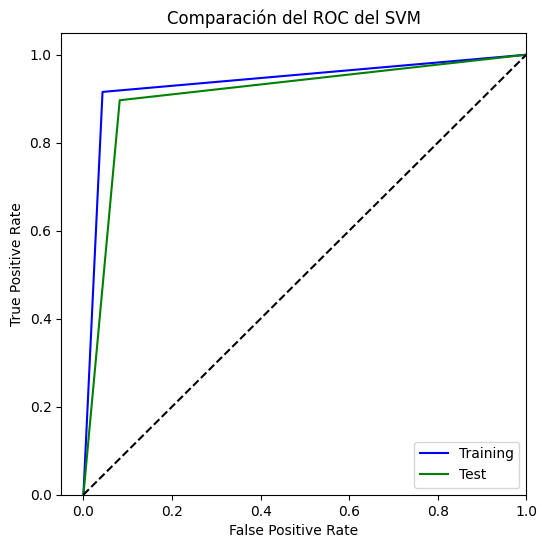

In [50]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6))

ax1.plot(false_pos_rate, true_pos_rate, label='Training' % roc_auc, color='b')
ax1.plot(false_pos_rate_test, true_pos_rate_test, label='Test' % roc_auc_test, color='g')
ax1.set_title('Comparación del ROC del SVM')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")